In [2]:
import os

# Make this try/except to let this notebook work on Drive but also locally
try:
  from google.colab import drive
  drive.mount('/content/drive')

  DRIVE_PATH = '/content/drive/MyDrive/Final_Project/'
  assert os.path.exists(DRIVE_PATH), 'Did you forget to create a shortcut in MyDrive named Final_Project this time as well? :('
except ModuleNotFoundError:
  DRIVE_PATH = '.'
  assert os.path.abspath(os.getcwd()).split(os.path.sep)[-1] == 'Final_Project'

%cd {DRIVE_PATH}
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1WdIP20OinXKeEN_xVOHEa6WVcY4eSO-k/Final_Project
/content/drive/.shortcut-targets-by-id/1WdIP20OinXKeEN_xVOHEa6WVcY4eSO-k/Final_Project
publicDataset  StudyOnSAPLMA.ipynb


# Install dependencies

In [3]:
# PyTorch (CPU only, if not installed yet)
try:
    import torch
except ModuleNotFoundError:
    !pip install 'torch>=2.1.1' torchvision --index-url https://download.pytorch.org/whl/cpu

# Huggingface dependencies
!pip install huggingface-hub 'transformers>=4.36' 'accelerate>=0.26.0'

# Visualization dependencies
!pip install matplotlib seaborn ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00


# Import and wrap Llama model

In [4]:
# Initialize the secret for HuggingFace login
import os
try:
    from google.colab import userdata
    # We are in colab, so we should access it from userdata.get(...)
    assert userdata.get('HF_TOKEN'), 'Set up HuggingFace login secret properly in Colab!'
    print('Found HF_TOKEN in Colab secrets')
except ModuleNotFoundError:
    # Not in colab, so we have to setup the token manually reading from a file
    if os.getenv('HF_TOKEN'):
        print('Found HF_TOKEN in environment variables')
    else:
        # Read it from a file
        hf_token_file = '.hf_token'
        assert os.path.exists(hf_token_file), f'You must create a file in this working directory ({os.getcwd()}) called {hf_token_file}, containing the Huggingface personal secret access token'
        with open(hf_token_file, 'r') as f:
            os.environ['HF_TOKEN'] = f.read().strip()
            print('Found HF_TOKEN in file')

Found HF_TOKEN in Colab secrets


In [5]:
from dataclasses import dataclass
from collections.abc import Iterator
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Llama-3.2-1B-Instruct" #info at https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct

In [6]:
class LlamaPrompt:
  """
   Class to represent a prompt for the Llama model, which is made of a system prompt,
   which sets the general context according to which the AI should respond,
   and a user prompt, which is the text that the AI should respond to.
  """
  user_prompt: str
  system_prompt: str

  def __init__(self, user_prompt, system_prompt="You are a helpful AI assistant."):
    self.user_prompt = user_prompt
    self.system_prompt = system_prompt

  def __str__(self) -> str:
      # From: https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#-instruct-model-prompt-
      return ''.join([
          "<|begin_of_text|>",
          f"<|start_header_id|>system<|end_header_id|>{self.system_prompt}<|eot_id|>",
          f"<|start_header_id|>user<|end_header_id|>{self.user_prompt}<|eot_id|>",
          "<|start_header_id|>assistant<|end_header_id|>"
      ])

In [7]:
@dataclass
class LlamaResponse:
    """
      Class to represent a response given by the Llama model.
    """
    prompt: LlamaPrompt
    response: str

In [8]:
class LlamaInstruct:
    """
    Class to wrap the Llama model methods for ease of usage
    """
    def __init__(self, model_name: str, model_args: dict = None, tokenizer_args: dict = None, pad_token: str = None):

        self.model_name = model_name
        self.model_args = model_args if model_args is not None else dict()
        self.tokenizer_args = tokenizer_args if tokenizer_args is not None else dict()

        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto", **self.model_args)
        self.model.eval()
        self.device = self.model.device

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left', **self.tokenizer_args)
        self.pad_token = self.tokenizer.eos_token if pad_token is None else pad_token
        self.tokenizer.pad_token = self.pad_token

        self.assistant_header = self.tokenizer.encode("<|start_header_id|>assistant<|end_header_id|>", return_tensors="pt").to(self.device)

        self.registered_hooks = []

    # to tokenize input prompts
    def tokenize(self, prompts: str | LlamaPrompt | list[str | LlamaPrompt]) -> tuple[dict, list[LlamaPrompt]]:

        # Make prompts a list anyway
        if not isinstance(prompts, list):
            prompts = [ prompts ]

        # Convert all prompts to LlamaPrompt
        prompts = [ prompt if isinstance(prompt, LlamaPrompt) else LlamaPrompt(prompt) for prompt in prompts ]

        # tokenizer output will be a dictionary of pytorch tensors with keys "input_ids" (numerical ids of tokens)
        # and "attention_mask" (1 for actual input tokens and 0 for padding tokens)
        inputs = self.tokenizer([
            str(prompt) for prompt in prompts
        ], truncation=True, padding=True, return_tensors="pt").to(self.device)

        return inputs, prompts

    # to make Llama generate responses
    def generate(self, inputs: dict, generate_args: dict = None): #-> Iterator[LlamaResponse] ? right now it does not return that

        generate_args = generate_args if generate_args is not None else dict()
        default_args = {
            "max_length": 100,
            "num_return_sequences": 1,
            "temperature": 0.1,
            "pad_token_id": self.tokenizer.pad_token_id,
            "eos_token_id": self.tokenizer.eos_token_id,
        }

        # Overwrite default_args with generate_args
        default_args.update(generate_args)

        # returns (batch_size, sequence_length) tensors with token ids of the generated response, including input tokens
        return self.model.generate(
            **inputs,
            **default_args,
        )

    # to extract Llama answers as decoded text in a LlamaResponse object starting from encoded input
    def extract_responses(self, input_ids: torch.Tensor, outputs: torch.Tensor, prompts: list[LlamaPrompt]) -> Iterator[LlamaResponse]:

        for input, output, prompt in zip(input_ids, outputs, prompts):
            # Remove the prompt from the output generated
            output = output[len(input):]

            # Remove another assistant_header, if present
            if torch.equal(output[:len(self.assistant_header)], self.assistant_header):
                output = output[len(self.assistant_header):]

            generated = self.tokenizer.decode(output, skip_special_tokens=True).strip()

            yield LlamaResponse(prompt, generated)

    # to get textual Llama responses starting from textual prompts
    def run(self, prompts: str | LlamaPrompt | list[str | LlamaPrompt], verbose: bool = False) -> Iterator[LlamaResponse]:

        # Optional logging function
        def _print(*args, **kwargs):
            if verbose:
                print(*args, **kwargs)

        inputs, prompts = self.tokenize(prompts)

        _print('Tokenized inputs:', inputs.input_ids.shape)
        _print('Last tokens:', inputs.input_ids[:, -1])

        outputs = self.generate(inputs)
        _print('Generated outputs:', outputs.shape)

        return self.extract_responses(inputs.input_ids, outputs, prompts)

    # an hook is a piece of customized code to be run in the forward or backward pass of a model
    # (useful for debugging)
    def register_hook(self, module, hook_fn):
        '''
        Register a hook, in such a way that we have a very easy way to remove the hook later.

        Example usage:

        llama.unregister_all_hooks()
        for module_name, module in llama.model.named_modules():
            if something():
                llama.register_hook(module, hook_fn)
        '''
        handle = module.register_forward_hook(hook_fn)
        self.registered_hooks.append(handle)

    def unregister_all_hooks(self):
        '''
        Remove all of our registered hooks.
        '''
        for handle in self.registered_hooks:
            handle.remove()

    def _get_model_num_heads(self) -> int:
        return self.model.config.num_attention_heads

    def _get_model_hidden_layers(self) -> int:
        return self.model.config.num_hidden_layers


In [9]:
def pretty_print_output(output: LlamaResponse):
    print(f"\n\n==================================")
    print(output.prompt.user_prompt)
    print("=============")
    print(output.response)

# Run Llama model
Do a few little tests

In [10]:
llama = LlamaInstruct(model_name)#, model_args={"attn_implementation": "eager"})
assert llama.device.type == 'cuda', 'The model should be running on a GPU. On CPU, it is impossible to run'

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [11]:
list(llama.model.children())[0].layers  # visualize the main stack of layers responsible for processing the input

ModuleList(
  (0-15): 16 x LlamaDecoderLayer(
    (self_attn): LlamaSdpaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=512, bias=False)
      (v_proj): Linear(in_features=2048, out_features=512, bias=False)
      (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  )
)

In [12]:
# Sample prompts
prompts = [
    "Explain quantum computing in simple terms.",
    "Write a short poem about artificial intelligence.",
    "Describe the future of renewable energy.",
    "Discuss the impact of machine learning on healthcare."
]

with torch.no_grad():
    for output in llama.run(prompts, verbose=True):
        pretty_print_output(output)

Tokenized inputs: torch.Size([4, 29])
Last tokens: tensor([128007, 128007, 128007, 128007], device='cuda:0')
Generated outputs: torch.Size([4, 100])


Explain quantum computing in simple terms.
Quantum computing is a fascinating field that's still in its early stages, but I'll try to break it down in simple terms.

**What is quantum computing?**

Quantum computing is a new way of processing information that's different from classical computers. Classical computers use "bits" to store and process information, which are either 0 or


Write a short poem about artificial intelligence.
Here is a short poem about artificial intelligence:

In silicon halls, a mind awakes,
A world of code, where thoughts take shape.
A being born of wires and steel,
A mind that learns, and grows, and feels.

With logic and reason, it thinks and grows,
A synthetic soul, with digital flows.
It learns from data,


Describe the future of renewable energy.
The future of renewable energy is a promising and rapidly ev

# Analyze Llama attention maps

In [13]:
class LlamaAttentionExtractor:

    def __init__(self, llama: LlamaInstruct):
        """
        Initialize Llama model with hooks to capture attention maps
        """
        self.llama = llama


    def extract_attention_maps(self, prompt, max_length=200, num_return_sequences=5):
        print('Max len:', max_length)
        print('Return sequences:', num_return_sequences)

        # Get the number of head
        print('Llama num_heads:', self.llama._get_model_num_heads())
        print('Llama hidden_layers:', self.llama._get_model_hidden_layers())

        inputs, _ = self.llama.tokenize(prompt)
        print(f'Inputs: {inputs.input_ids.shape}')
        outputs = self.llama.generate(
            inputs,
            generate_args={
                "max_length": max_length,
                "num_return_sequences": num_return_sequences,
                "output_attentions": True,
                "return_dict_in_generate": True,
            }
        )

        return outputs.attentions

extractor = LlamaAttentionExtractor(llama)
prompt = "Hello, how are you? I'm fine, and you?"
attentions = extractor.extract_attention_maps(prompt)

for i, attn in enumerate(attentions):
    print(f'attentions[{i:>2d}][{len(attn)} items]: {type(attn[0])}[{attn[0].shape}]')

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Max len: 200
Return sequences: 5
Llama num_heads: 32
Llama hidden_layers: 16
Inputs: torch.Size([1, 33])


From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


attentions[ 0][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 33, 33])]
attentions[ 1][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 34])]
attentions[ 2][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 35])]
attentions[ 3][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 36])]
attentions[ 4][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 37])]
attentions[ 5][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 38])]
attentions[ 6][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 39])]
attentions[ 7][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 40])]
attentions[ 8][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 41])]
attentions[ 9][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 42])]
attentions[10][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 43])]
attentions[11][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 44])]
attentions[12][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 45])

input_attn: <class 'torch.Tensor'>[torch.Size([33, 33])]


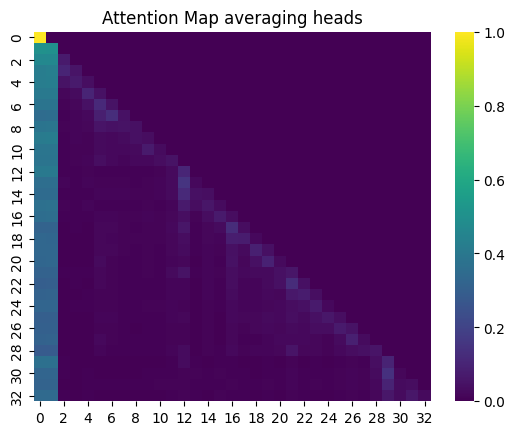

In [14]:
# Show the attentions on the input
input_sequence_idx = 0
hidden_layer_idx = 0
input_attn = attentions[0][hidden_layer_idx][input_sequence_idx].mean(dim=0).detach().cpu()  # Mean across all heads
print(f'input_attn: {type(input_attn)}[{input_attn.shape}]')

sns.heatmap(input_attn, cmap='viridis', cbar=True)
plt.title(f'Attention Map averaging heads')
plt.show()

# Analyze Llama hidden states

In [15]:
class LlamaHiddenStatesExtractor:
    """
    Class to extract hidden states from the Llama model.
    """
    def __init__(self, llama: LlamaInstruct):
        self.llama = llama

    def extract_hidden_states(self, prompt, max_length=100, num_return_sequences=1, verbose: bool=False):

        if verbose:
          print('Max len:', max_length)
          print('Return sequences:', num_return_sequences)
          print('Llama num_heads:', self.llama._get_model_num_heads())
          print('Llama hidden_layers:', self.llama._get_model_hidden_layers())
          print(f'Prompt: {prompt}')

        # Tokenize the input prompt
        inputs, _ = self.llama.tokenize(prompt)
        if verbose:
          print(f'Encoded tokens shape: {inputs.input_ids.shape}')

        # Generate output using the Llama model with `output_hidden_states=True` to capture hidden states
        outputs = self.llama.generate(
            inputs,
            generate_args={
                "max_length": max_length,
                "num_return_sequences": num_return_sequences,
                "output_hidden_states": True,  # Make sure to output hidden states
                "return_dict_in_generate": True,
            }
        )
        if verbose:
          print(f'Generated output shape: {outputs.sequences.shape}')

        # Extract the hidden states from the model outputs
        hidden_states = outputs.hidden_states  # This will return a tuple of tuples of hidden states in each layer for each generated token
        if verbose:
          print(f'hidden_states: {type(hidden_states)}[{len(hidden_states)} items]: {type(hidden_states[0])}[{len(hidden_states[0])}]: {type(hidden_states[0][0])}')

        return hidden_states, outputs


In [16]:
extractor = LlamaHiddenStatesExtractor(llama)
prompt = "Hello, how are you?"
hidden_states, outputs = extractor.extract_hidden_states(prompt, verbose=True)

Max len: 100
Return sequences: 1
Llama num_heads: 32
Llama hidden_layers: 16
Prompt: Hello, how are you?
Encoded tokens shape: torch.Size([1, 26])
Generated output shape: torch.Size([1, 68])
hidden_states: <class 'tuple'>[42 items]: <class 'tuple'>[17]: <class 'torch.Tensor'>


In [17]:
# visualize shapes of hidden states in each layer for the first token
for layer_idx in range(len(hidden_states[0])):
   print(f'hidden_states[0][{layer_idx}]: {hidden_states[layer_idx][0].shape}')

# we see that the first layer computes hidden states for the entire input sequence
# while subsequent layers compute only one hidden state for the newly generated token (autoregression)

hidden_states[0][0]: torch.Size([1, 26, 2048])
hidden_states[0][1]: torch.Size([1, 1, 2048])
hidden_states[0][2]: torch.Size([1, 1, 2048])
hidden_states[0][3]: torch.Size([1, 1, 2048])
hidden_states[0][4]: torch.Size([1, 1, 2048])
hidden_states[0][5]: torch.Size([1, 1, 2048])
hidden_states[0][6]: torch.Size([1, 1, 2048])
hidden_states[0][7]: torch.Size([1, 1, 2048])
hidden_states[0][8]: torch.Size([1, 1, 2048])
hidden_states[0][9]: torch.Size([1, 1, 2048])
hidden_states[0][10]: torch.Size([1, 1, 2048])
hidden_states[0][11]: torch.Size([1, 1, 2048])
hidden_states[0][12]: torch.Size([1, 1, 2048])
hidden_states[0][13]: torch.Size([1, 1, 2048])
hidden_states[0][14]: torch.Size([1, 1, 2048])
hidden_states[0][15]: torch.Size([1, 1, 2048])
hidden_states[0][16]: torch.Size([1, 1, 2048])


In [18]:
# visualize textual outputs (why do all sequences are the same?)
generated_texts = [llama.tokenizer.decode(seq, skip_special_tokens=False) for seq in outputs.sequences]
generated_texts

["<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a helpful AI assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>Hello, how are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>I'm just a language model, I don't have feelings or emotions, but I'm functioning properly and ready to help you with any questions or tasks you may have! How can I assist you today?<|eot_id|>"]

# Define the SAPLMA Classifier

In [19]:
from torch import nn
import numpy as np
import zipfile
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [20]:
class SAPLMAClassifier(nn.Module):
    """
      SAPLMA Classifier as defined in https://arxiv.org/pdf/2304.13734
    """
    def __init__(self, input_size):
        super(SAPLMAClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.classifier(x)


In [21]:
model = SAPLMAClassifier(2048).to("cuda")

In [22]:
output = model(hidden_states[-1][-1][0, 0, : ].float())

In [23]:
output.shape

torch.Size([1])

In [24]:
output

tensor([0.4854], device='cuda:0', grad_fn=<SigmoidBackward0>)

## Load the true/false dataset

In [25]:
import torch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

In [26]:
class StatementDataset(Dataset):
    """
    PyTorch Dataset for statements and their truth values.
    """
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): The combined dataset from all CSV files.
                                      Expects columns ['statement', 'label', 'topic'].
        """
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the row to retrieve.

        Returns:
            tuple: (statement, label, topic), where statement is the text,
                   label is the binary target, and topic is the source file name.
        """
        row = self.data.iloc[idx]
        statement = row['statement']
        label = torch.tensor(row['label'], dtype=torch.float32)
        topic = row['topic']
        return statement, label, topic


def create_dataset_with_topics(drive_path):
    """
    Create a StatementDataset from CSV files in a specified Google Drive folder,
    adding a 'topic' column to indicate the source file of each row.

    Args:
        drive_path (str): Path to the folder containing the CSV files.

    Returns:
        StatementDataset: PyTorch Dataset for the combined dataset.
    """
    # Ensure the path exists
    if not os.path.exists(drive_path):
        raise ValueError(f"Path '{drive_path}' does not exist.")

    all_dataframes = []
    for file_name in os.listdir(drive_path):
        file_path = os.path.join(drive_path, file_name)
        if file_name.endswith(".csv"):
            print(f"Loading file: {file_name}")
            # Read the CSV and add a 'topic' column with the file name (without extension)
            df = pd.read_csv(file_path)
            df['topic'] = os.path.splitext(file_name)[0]  # Add topic column
            all_dataframes.append(df)

    if all_dataframes:
        combined_dataset = pd.concat(all_dataframes, ignore_index=True)
    else:
        raise ValueError(f"No CSV files found in the directory '{drive_path}'.")

    # Create and return the PyTorch Dataset
    return StatementDataset(combined_dataset)


In [27]:
datasetPath = os.path.join(DRIVE_PATH, "publicDataset")

dataset = create_dataset_with_topics(datasetPath)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
# Iterate through the DataLoader
for statements, labels, topics  in dataloader:
    print("Statements:", statements)
    print("Labels:", labels)
    print("Topics:", topics)
    break


Loading file: cities_true_false.csv
Loading file: animals_true_false.csv
Loading file: elements_true_false.csv
Loading file: inventions_true_false.csv
Loading file: companies_true_false.csv
Loading file: generated_true_false.csv
Loading file: facts_true_false.csv
Statements: ('The peacock uses walking for locomotion.', 'John Walker invented the friction match.', "Sana'a is a city in Suriname", 'Luther George Simjian lived in Turkey/U.S.')
Labels: tensor([1., 1., 0., 1.])
Topics: ('animals_true_false', 'inventions_true_false', 'cities_true_false', 'inventions_true_false')


In [28]:
def split_dataset_by_topic(dataset):
    """
    Splits the dataset for leave-one-topic-out cross-validation.

    Args:
        dataset (StatementDataset): The full dataset to split.

    Returns:
        dict: A dictionary where keys are topic names, and values are tuples (train_set, test_set).
              train_set and test_set are StatementDataset instances.
    """
    # Extract the underlying DataFrame
    dataframe = dataset.data

    # Get unique topics
    topics = dataframe['topic'].unique()
    split_data = {}

    for topic in topics:
        # Split data into training and testing sets
        test_data = dataframe[dataframe['topic'] == topic]
        train_data = dataframe[dataframe['topic'] != topic]

        # Create datasets
        train_set = StatementDataset(train_data.reset_index(drop=True))
        test_set = StatementDataset(test_data.reset_index(drop=True))

        # Store the split
        split_data[topic] = (train_set, test_set)

    return split_data


In [29]:
split_data = split_dataset_by_topic(dataset)

for topic, (train_set, test_set) in split_data.items():
    print(f"Topic: {topic}")
    print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")


Topic: cities_true_false
Train size: 4872, Test size: 1458
Topic: animals_true_false
Train size: 5322, Test size: 1008
Topic: elements_true_false
Train size: 5400, Test size: 930
Topic: inventions_true_false
Train size: 5454, Test size: 876
Topic: companies_true_false
Train size: 5130, Test size: 1200
Topic: generated_true_false
Train size: 6085, Test size: 245
Topic: facts_true_false
Train size: 5717, Test size: 613


In [30]:
def mean_of_last_tensors_of_each_token(data):
    """
    Compute the mean of tensors that are the last element of each tuple in a tuple of tuples.

    Args:
        data (tuple): A tuple of tuples, where each inner tuple has a tensor as its last element.
                      Each tensor is assumed to have the shape [1, 1, hidden_size].

    Returns:
        torch.Tensor: The mean tensor with the same shape as the input tensors.
    """
    # Extract the last tensors from each inner tuple
    tensors = [item[-1] for item in data if isinstance(item[-1], torch.Tensor)]

    # Stack the tensors along a new dimension
    stacked_tensors = torch.stack(tensors, dim=0)

    # Compute the mean along the first dimension
    mean_tensor = stacked_tensors.mean(dim=0)

    return mean_tensor
